In [76]:
import mmap
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [77]:
length = 0
csv_file = open('./climate-change-data/GlobalLandTemperaturesByCountry.csv', 'r+', encoding='utf-8')
mapped_file = mmap.mmap(csv_file.fileno(), length, access=mmap.ACCESS_WRITE)
mapped_file.readline() # Skips first line (headers)
current_line = ''
batch_size = 200
final_df = pd.DataFrame({"Year": pd.Series(dtype='int'),
                         "AverageTemperature": pd.Series(dtype='float'),
                         "n_records": pd.Series(dtype='int')})
while current_line != b"":
    df = pd.DataFrame({"Year": pd.Series(dtype='str'),
                       "AverageTemperature": pd.Series(dtype='float'),
                       "Country": pd.Series(dtype='str')})
    for _ in range(batch_size):
        current_line = mapped_file.readline()
        if current_line != b"":
            current_df = pd.read_csv(StringIO(current_line.decode(encoding='utf-8')), names=['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'])
            current_df = current_df[['Year', 'AverageTemperature', 'Country']]
            df = pd.concat([df, current_df])

    df['Year'] = df['Year'].str[0:4]
    df['n_records'] = 1
    df.dropna(inplace=True)
    mean_years = df.groupby('Year').sum().reset_index()
    final_df = pd.concat([final_df, mean_years])
    final_df = final_df.groupby('Year').sum()
    final_df.reset_index(inplace=True)
final_df.to_csv('GlobalTemperaturesByYear.csv')

In [78]:
csv_file = open('./GlobalTemperaturesByYear.csv', 'r+', encoding='utf-8')
mapped_file = mmap.mmap(csv_file.fileno(), length, access=mmap.ACCESS_WRITE)
mapped_file.readline()
current_line = ''
batch_size = 20
final_df = pd.DataFrame({"Year": pd.Series(dtype='int'),
                         "AverageTemperature": pd.Series(dtype='float')})
while current_line != b"":
    df = pd.DataFrame({"Year": pd.Series(dtype='int'),
                       "AverageTemperature": pd.Series(dtype='float'),
                       "n_records": pd.Series(dtype='int')})
    for _ in range(batch_size):
        current_line = mapped_file.readline()
        if current_line != b"":
            current_df = pd.read_csv(StringIO(current_line.decode(encoding='utf-8')), names=['Year', 'AverageTemperature', 'n_records'])
            df = pd.concat([df, current_df])
            df = df[df['Year'] >= 1750]
    if df.shape[0] != 0:
        df['AverageTemperature'] = df['AverageTemperature'] / df['n_records']
        final_df = pd.concat([final_df, df[['Year', 'AverageTemperature']]])


,Year,AverageTemperature
3,1750,9.129353
4,1751,9.167388
5,1752,4.413387
6,1753,8.870821
7,1754,8.822019
...,...,...
262,2009,19.546385
263,2010,19.629806
264,2011,19.456040
265,2012,19.468744


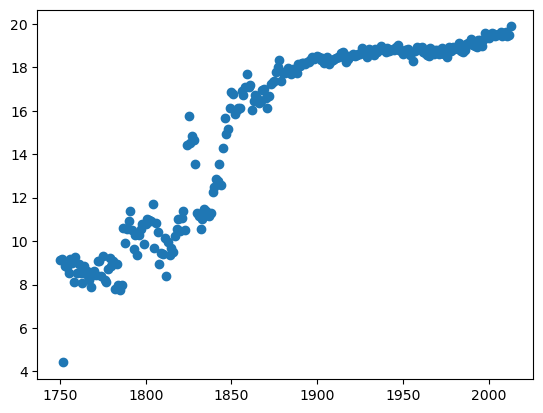

In [79]:
final_df['Year'] = final_df['Year'].astype(int)
plt.scatter(final_df['Year'], final_df['AverageTemperature'])
final_df

0.8350672959938121

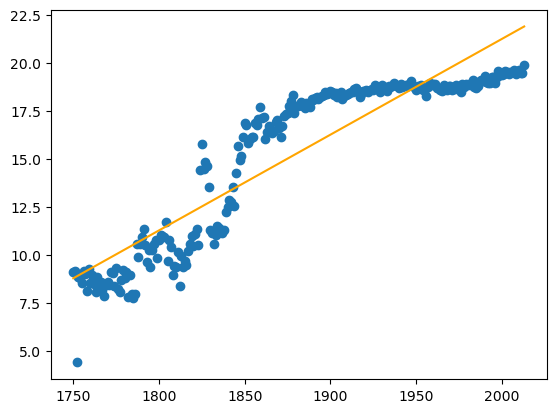

In [80]:
X = np.asarray(final_df['Year'])
X = X.reshape(-1, 1)
y = final_df['AverageTemperature']
model = LinearRegression().fit(X, y)
year_range = np.arange(1750, 2014, 1)
m = model.coef_
b = model.intercept_
temp_range = m * year_range + b
plt.plot(year_range, temp_range, 'orange')
plt.scatter(final_df['Year'], final_df['AverageTemperature'])
model.score(X, y)

6

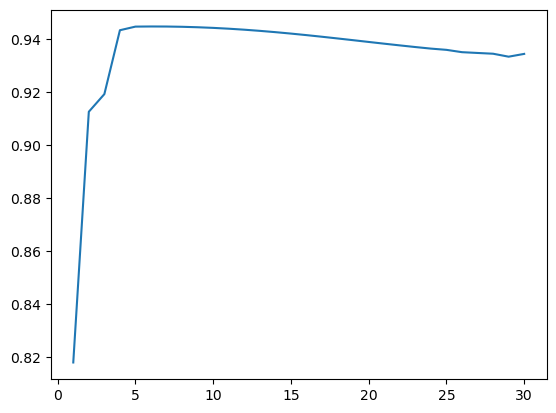

In [81]:
max_degree = 30
degrees = range(1, max_degree+1)
cv_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
for d in degrees:
    X_poly_train = PolynomialFeatures(degree=d).fit_transform(X_train)
    X_poly_test = PolynomialFeatures(degree=d).fit_transform(X_test)
    model = LinearRegression().fit(X_poly_train, y_train)
    scores = cross_val_score(model, X_poly_train, y_train)
    cv_scores.append(np.mean(scores))
plt.plot(degrees, cv_scores)
best_degree = degrees[np.argmax(cv_scores)]
best_degree

0.9665568867732375

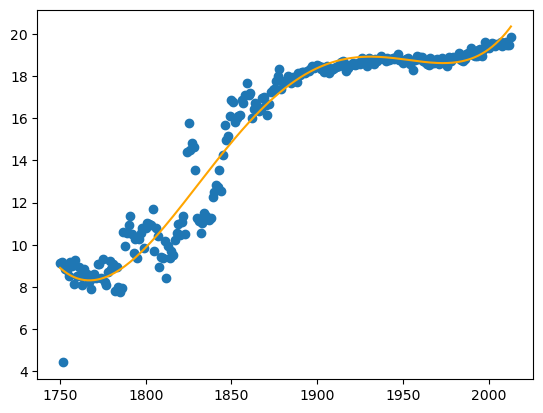

In [82]:
X_poly_train = PolynomialFeatures(degree=best_degree).fit_transform(X_train)
X_poly_test = PolynomialFeatures(degree=best_degree).fit_transform(X_test)
model = LinearRegression().fit(X_poly_train, y_train)
X_poly = PolynomialFeatures(degree=best_degree).fit_transform(X)
y_preds = model.predict(X_poly)
plt.plot(X, y_preds, 'orange')
plt.scatter(X, y)
model.score(X_poly_test, y_test)